In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, Bounds
from nelson_siegel_svensson.calibrate import errorfn_ns_ols, betas_ns_ols

# Loading dataset

In [2]:
def read_files(path, filenames):
    """Reads all files and returns a dataframe"""
    return pd.concat((pd.read_csv(path + f, skipinitialspace=True) for f in filenames))

In [3]:
path_opt = "./data/raw_data/"
filenames_opt = ["spx_eod_" + str(year) + (str(month) if month >= 10 else "0" + str(month)) + ".csv" for year in range(2010, 2023) for month in range(1, 13)] + ["spx_eod_2023" + (str(month) if month >= 10 else "0" + str(month)) + ".csv" for month in range(1, 4)]
df = read_files(path_opt, filenames_opt)

In [4]:
len_after_first_read = len(df)

# Cleaning raw data

In [5]:
def process_options(df_opt, call = True):
    """Cleans up column names and add time to maturity (TTM)"""
    keys = {key: key[key.find("[")+1:key.find("]")][0] + key[key.find("[")+1:key.find("]")][1:].lower() for key in df_opt.keys()}
    df_opt = df_opt.rename(columns=keys)
    pd.set_option('display.max_columns', None)

    if call:
        keys = {"C_ask": "Ask", "C_bid": "Bid", "C_iv": "IV"}
    else:
        keys = {"P_ask": "Ask", "P_bid": "Bid"}
    df_opt = df_opt.rename(columns=keys)
    
    df_opt["Quote_date"] = pd.to_datetime(df_opt["Quote_date"])
    df_opt["Expire_date"] = pd.to_datetime(df_opt["Expire_date"])
    # Filter out options with TTM = 0
    df_opt["TTM"] = df_opt.apply(lambda row: ((row.Expire_date - row.Quote_date).days / 365), axis = 1)
    df_opt = df_opt[df_opt["TTM"] > 0]
    df_opt["Price"] = (df_opt["Ask"] + df_opt["Bid"])/2

    columns = ["Quote_date", "Expire_date", "Price", "Underlying_last", "Strike", "TTM", "IV"]
    df_opt = df_opt[columns]
    return df_opt[columns]

In [6]:
df = process_options(df)
len_after_process = len(df)

df = df.dropna()
len_after_nan = len(df)

# Matching rates

In [7]:
def process_rates(df_r):
    """Renames rate duration"""
    # df_r date in format MM/DD/YYYY. Turn to YYYY-MM-DD
    df_r["Date"] = pd.to_datetime(df_r["Date"])
    # Rename the Date to Quote_date in both dataframes
    df_r = df_r.rename(columns={"Date": "Quote_date"})
    df_r = df_r.rename(columns={"1 Mo": 0.08333333333333333, "3 Mo": 0.25, "6 Mo": 0.5, "1 Yr": 1, "2 Yr": 2})
    # Filter df_r to after 2010-01-01
    df_r = df_r[df_r["Quote_date"] >= "2010-01-01"]
    # Only keep the renamed columns
    df_r = df_r[["Quote_date", 0.08333333333333333, 0.25, 0.5, 1, 2]]
    return df_r
    

def combine_opt_rates(df_opt, df_r):
    df_opt = pd.merge(df_opt, df_r, on="Quote_date", how="left")
    rates = list(df_r.columns)
    rates.remove("Quote_date")
    df_opt = df_opt.ffill()

    # Apply Nelson Siegel Svensson model for interpolation of rates and matching of TTM
    df_opt = df_opt.dropna()
    groups = df_opt.groupby("Quote_date")

    # Create an empty DataFrame to store the modified groups
    df_opt_modified = pd.DataFrame()

    num_linear = 0
    linear_groups = []
    for _, group in groups:
        # Convert TTM to years
        yield_maturities = np.array([x for x in rates])
        yields = np.array(group[rates].values.tolist()[1])
        try:
            # Calibrate with bounds on tau
            tau0 = 1.0
            bounds = Bounds([0.1], [100])
            opt_res = minimize(errorfn_ns_ols, x0=tau0, args=(yield_maturities, yields), bounds=bounds)
            
            if opt_res.success:
                curve, _ = betas_ns_ols(opt_res.x[0], yield_maturities, yields)
                group["R"] = group["TTM"].apply(lambda x: curve(x))

                # If TTM < 1/12 then use the 1 month rate
                group["R"] = group.apply(lambda row: row[0.08333333333333333] if row["TTM"] < 1/12 else row["R"], axis = 1)

                # Append the modified group to the df_opt_modified DataFrame
                df_opt_modified = pd.concat([df_opt_modified, group], ignore_index=True)
            else:
                print(f"Optimization failed for {group['Quote_date'].unique()[0]}, so using linear interpolation instead")
                yield_maturities = np.array([x for x in rates])
                # Print yield_maturities with all decimals
                np.set_printoptions(formatter={'float': lambda x: "{0:0.15f}".format(x)})
                yields = np.array(group[rates].values.tolist()[1])

                # Linear interpolation for all points
                curve = np.interp(group["TTM"], yield_maturities, yields)
                group["R"] = curve

                # If TTM < 1/12 then use the 1 month rate
                one_month_rate = group[0.08333333333333333].values[0]
                group["R"] = group.apply(lambda row: one_month_rate if row["TTM"] < 1/12 else row["R"], axis = 1)

                df_opt_modified = pd.concat([df_opt_modified, group], ignore_index=True)
                num_linear += 1
                linear_groups.append(group["Quote_date"].values[0])
        except Exception as e:
            print(f"None of the interpolations worked {group['Quote_date'].values[0]}: {e}")

    print(f"Using {num_linear} groups")
    print("These are: ", linear_groups)


    df_opt_modified = df_opt_modified.ffill()
    df_opt_len_before = len(df_opt_modified)
    df_opt_modified = df_opt_modified.dropna()
    df_opt_len_after = len(df_opt_modified)
    return df_opt_modified.dropna()



def combine_opt_rates_lin(df_opt, df_r):
    df_opt = pd.merge(df_opt, df_r, on="Quote_date", how="left")
    df_opt = df_opt.ffill()
    rates = list(df_r.columns)
    rates.remove("Quote_date")

    df_opt = df_opt.dropna()
    groups = df_opt.groupby("Quote_date")

    df_opt_modified = pd.DataFrame()

    for _, group in groups:
        yield_maturities = np.array([x for x in rates])
        # Print yield_maturities with all decimals
        np.set_printoptions(formatter={'float': lambda x: "{0:0.15f}".format(x)})
        yields = np.array(group[rates].values.tolist()[1])

        # Linear interpolation for all points
        curve = np.interp(group["TTM"], yield_maturities, yields)
        group["R"] = curve

        # If TTM < 1/12 then use the 1 month rate
        one_month_rate = group[0.08333333333333333].values[0]
        group["R"] = group.apply(lambda row: one_month_rate if row["TTM"] < 1/12 else row["R"], axis = 1)
        df_opt_modified = pd.concat([df_opt_modified, group], ignore_index=True)

    df_opt_len_before = len(df_opt_modified)
    df_opt_modified = df_opt_modified.dropna()
    df_opt_len_after = len(df_opt_modified)
    return df_opt_modified.dropna()


In [8]:
df_r = pd.concat((pd.read_csv("./data/raw_data/" + f, skipinitialspace=True) for f in ["daily-treasury-rates.csv", "daily-treasury-rates_2023.csv", "yield-curve-rates-1990-2021.csv"]))
df_r = process_rates(df_r)

len_before_dfr = len(df_r)
df_r = df_r.dropna()
len_after_rates_dropes_nan = len(df_r)

df = combine_opt_rates(df, df_r)
len_after_rate_matching = len(df)

Optimization failed for 2011-03-24T00:00:00.000000000, so using linear interpolation instead
Optimization failed for 2016-10-07T00:00:00.000000000, so using linear interpolation instead
Optimization failed for 2016-10-10T00:00:00.000000000, so using linear interpolation instead
Optimization failed for 2019-07-10T00:00:00.000000000, so using linear interpolation instead
Using 4 groups
These are:  [numpy.datetime64('2011-03-24T00:00:00.000000000'), numpy.datetime64('2016-10-07T00:00:00.000000000'), numpy.datetime64('2016-10-10T00:00:00.000000000'), numpy.datetime64('2019-07-10T00:00:00.000000000')]


# Filtering

In [9]:
# Filter out options with TTM < 2 years
df = df[df["TTM"] <= 2]
len_after_ttm = len(df)

# Filter moneyness
df["Moneyness"] = df['Underlying_last'] / df["Strike"]

df = df[(df['Moneyness'] >= 0.8) & (df['Moneyness'] <= 2)]
len_after_moneyness = len(df)

df["R"] = df["R"].apply(lambda x: x / 100)

## Analysing lost data

In [10]:
print("Starting with " + str(len_after_first_read) + " rows, and ended up with " + str(len_after_moneyness) + " rows")
print("Dropped " + str(len_after_first_read - len_after_moneyness) + " rows in total")
print("Which is " + str(round((len_after_first_read - len_after_moneyness)/len_after_first_read*100, 2)) + "%")
print("Droppend ", len_after_first_read - len_after_process, " rows due to filtering TTM = 0 and first drop nan")
print("Droppend ", len_after_process - len_after_nan, " rows due removing NaN in option data")
print("Droppend ", len_after_nan - len_after_rate_matching, " rows during matching options with rates")
print("Droppend ", len_after_rate_matching - len_after_ttm, " rows due to filtering TTM < 2 years")
print("Droppend ", len_after_ttm - len_after_moneyness, " rows due to filtering moneyness")

Starting with 14016676 rows, and ended up with 9422928 rows
Dropped 4593748 rows in total
Which is 32.77%
Droppend  266416  rows due to filtering TTM = 0 and first drop nan
Droppend  3519839  rows due removing NaN in option data
Droppend  0  rows during matching options with rates
Droppend  230935  rows due to filtering TTM < 2 years
Droppend  576558  rows due to filtering moneyness


In [11]:
# Only keep Quote_date	Price	Underlying_last	Strike	TTM R
df = df[["Quote_date", "Price", "Underlying_last", "Strike", "TTM", "R", "IV"]]

## Read to file

In [12]:
df.to_csv("./data/processed_data/2010-2023_NSS_filtered_with_IV.csv")

## Analysis

In [13]:
print(df["Quote_date"].min())
print(df["Quote_date"].max())

print("Num unique days before: ", len(df["Quote_date"].unique()), " and after: ", len(df["Quote_date"].unique()))


2010-01-04 00:00:00
2023-03-31 00:00:00
Num unique days before:  3303  and after:  3303


In [14]:
display(df[df["Quote_date"]=="2019-07-10"])

,Quote_date,Price,Underlying_last,Strike,TTM,R,IV
4412682,2019-07-10,243.100,2993.01,2750.0,0.005479,0.021800,0.34281
4412683,2019-07-10,208.090,2993.01,2785.0,0.005479,0.021800,0.29656
4412684,2019-07-10,193.105,2993.01,2800.0,0.005479,0.021800,0.27653
4412685,2019-07-10,188.095,2993.01,2805.0,0.005479,0.021800,0.26976
4412686,2019-07-10,183.100,2993.01,2810.0,0.005479,0.021800,0.26317
...,...,...,...,...,...,...,...
4417182,2019-07-10,97.295,2993.01,3350.0,1.942466,0.018263,0.15519
4417183,2019-07-10,82.145,2993.01,3400.0,1.942466,0.018263,0.15148
4417184,2019-07-10,57.800,2993.01,3500.0,1.942466,0.018263,0.14527
4417185,2019-07-10,40.150,2993.01,3600.0,1.942466,0.018263,0.14054


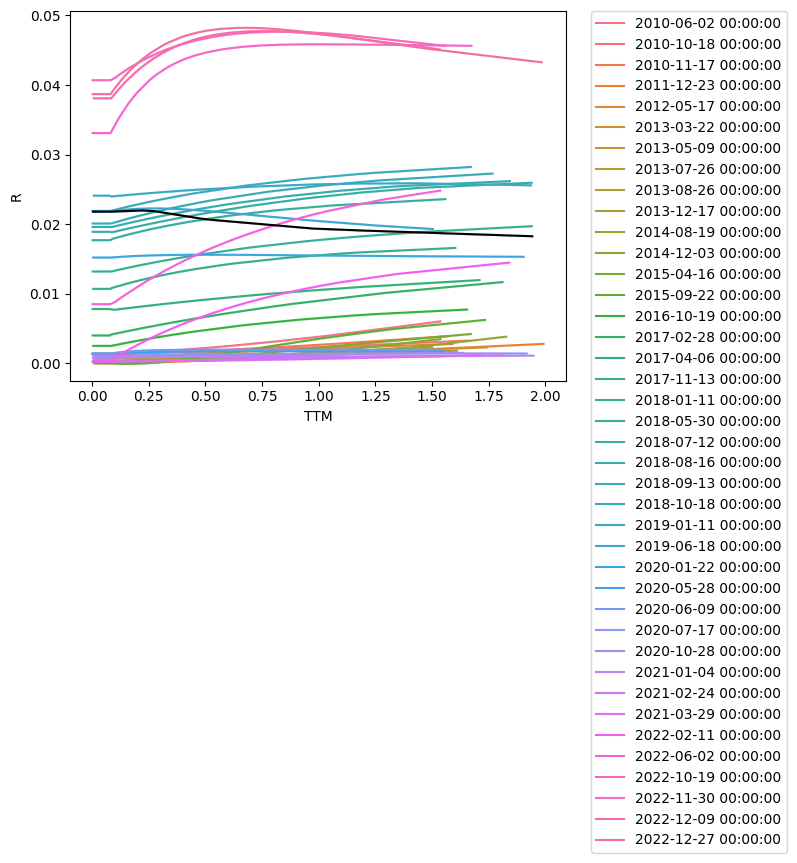

In [15]:
# Import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe from 60 random dates
dates = df["Quote_date"].unique()
dates = np.random.choice(dates, 40, replace=False)
df_sample = df[df["Quote_date"].isin(dates)]



# Plot 60 line chart for R with respect to TTM by having Quote_date as hue
sns.lineplot(data=df_sample, x="TTM", y="R", hue="Quote_date")

# Also plot the line for 2019-07-10 as example of linear interpolation
sns.lineplot(data=df[df["Quote_date"]=="2019-07-10"], x="TTM", y="R", color="black")

# Make the legend be outside of the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# vertical lines for 1 month,  3 month,  6 month, 1 year and 2 year
#plt.axvline(x=0.08333333333333333, color='black', linestyle='--')
#plt.axvline(x=0.25, color='black', linestyle='--')
#plt.axvline(x=0.5, color='black', linestyle='--')
#plt.axvline(x=1, color='black', linestyle='--')
#plt.axvline(x=2, color='black', linestyle='--')

plt.show()